In [1]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy import stats

In [2]:
alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/'
#xr.open_dataset( '/home/gemeinsam_tmp/UA_students/data/Col/Meteor_radar_Col_GW_201903.h5', group='info')['day']

# Meteor radars

* Dav        Davis; GW:200501-201912
* Col         Collm (Leipzig); GW:200408-201903
* Rio         RioGrande (SAAMER- Argentina); GW:200802-201912
* Sod        Sodankyla; GW:200810-201912
* Kir          Kiruna (Sweden ? Esrange); GW:199908-201912
* CMA      CMOR (Canada ? CMA (CMOR All) triple frequency data); GW:200201-201812
* SES        Sodankyla ? Esrange merged (assigned either to Esrange or Sodankyla or a virtual center in between); GW:199908-201912

# FUNCTIONS

### lineare regression

In [3]:
def new_linregress(y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])


In [4]:
def time_reg(var):
    statistics = xr.apply_ufunc(new_linregress, var, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="allowed",
                       output_dtypes=['float64'],
                       output_sizes={"parameter": 5},
                      )
    return statistics

### Variable einlesen

In [5]:
def read_group(gruppe,loc):
    station = loc#ersten Buchstaben bitte bitte groß schreiben
    infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
    ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = gruppe, combine='nested', parallel = True)
    ds = ds.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
    ds['alt'] = alt
    ds['alt'].attrs['units'] = 'km'
    # change time range according to meteor radar station
    ds['time'] = pd.date_range(start = '2004-08-01', end = '2019-03-06', periods = ds.time.shape[0]) 
    return ds
    

In [6]:
def read_var(gruppe, var):
        varout = gruppe[var]
        return varout

### Horizontal Wind

In [7]:
def hwind(u,v):
    return np.sqrt(u**2+v**2)
    

### time mean

In [8]:
def time_mean(step,var):
    return var.resample(time='1'+step).mean('time') #Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!
    
    

### Amomalies

In [9]:
def anomalie(step,var):
    string = "time."+step   
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology
    return anomalies




## Collm

In [10]:
ds_col= read_group('wind','Col')
u_col = read_var(ds_col,'u')  
v_col = read_var(ds_col,'v')
hwind_col = hwind(u_col,v_col)
hwind_ano_col=anomalie('month',hwind_col)
hwind_col_monthly = time_mean('M',hwind_col) 

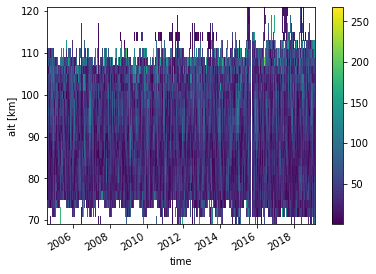

In [11]:

hwind_col.plot(x='time')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


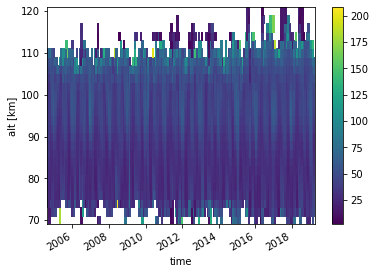

In [12]:
hwind_col_monthly.plot(x='time')

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


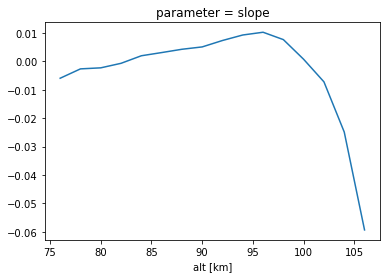

In [14]:
x = np.arange(hwind_col_monthly.time.shape[0])
statistics = time_reg(hwind_col_monthly)
statistics['parameter'] = ['slope', 'intercept', 'r_value','p_value', 'std_err']
statistics.sel(parameter='slope').plot()

### Gravity waves

In [ ]:
var = 'u'
da_jul_gwu = ds_jul[var]-ds_jul[f'{var}_fil']
var = 'v'
da_jul_gwv = ds_jul[var]-ds_jul[f'{var}_fil']
da_jul_gw_total = 0.5*(da_jul_gwu**2+ da_jul_gwv**2) # kinetic energy

In [ ]:
da_jul_gw_total.plot(x = 'time', robust = True, vmax = 400, vmin = 0)

#### Climatology calculation

In [ ]:
da_jul_gw_total_clim = da_jul_gw_total.groupby('time.month').mean('time').load()
da_jul_gw_total_clim

In [ ]:
da_jul_gw_total_clim.plot(x = 'month', robust = True)

In [ ]:
station = 'Rio'
infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
ds_jul = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = 'wind', combine='nested', parallel = True)
ds_jul = ds_jul.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
ds_jul['alt'] = alt_jul
ds_jul['alt'].attrs['units'] = 'km'
ds_jul['time'] = pd.date_range(start = '2008-02-01', end = '2019-12-31', periods = ds_jul.time.shape[0])
ds_jul

In [ ]:
var = 'u'
da_jul_gwu = ds_jul[var]-ds_jul[f'{var}_fil']
var = 'v'
da_jul_gwv = ds_jul[var]-ds_jul[f'{var}_fil']
da_jul_gw_total = 0.5*(da_jul_gwu**2+ da_jul_gwv**2)
da_jul_gw_total_clim = da_jul_gw_total.groupby('time.month').mean('time').load()
da_jul_gw_total_clim

In [ ]:
da_jul_gw_total_clim.plot(x = 'month', robust = True)

# GAIA

## Rio

In [ ]:
root_path = '/projekt4/hochatm/akuchar/GAIA_analysis/'
infile = f'{root_path}GAIA_Rio_20080201_20141231_run20200327.nc'
ds = xr.open_dataset(infile, group='GAIA')
ds['time'] = pd.date_range(start = '2008-02-01', end = '2014-12-31', periods=ds.time.shape[0])
ds

### Tides amplitude in zonal wind (climatology)

#### Diurnal

In [ ]:
temp = ds['A24u'].sel(alt = slice(80,100)).groupby('time.month').mean('time')
temp.plot.contourf(x = 'month', robust = True, levels = 21)

#### Semi-diurnal

In [ ]:
temp = ds['A12u'].sel(alt = slice(80,100)).groupby('time.month').mean('time')
temp.plot.contourf(x = 'month', robust = True, levels = 21)

#### Terdiurnal

In [ ]:
temp = ds['A8u'].sel(alt = slice(80,100)).groupby('time.month').mean('time')
temp.plot.contourf(x = 'month', robust = True, levels = 21)

### Gravity waves

In [ ]:
var = 'u'
da_gwu = ds[var]-ds[f'{var}_fil']
var = 'v'
da_gwv = ds[var]-ds[f'{var}_fil']
da_gw_total = 0.5*(da_gwu**2+ da_gwv**2)
da_gw_total_clim = da_gw_total.groupby('time.month').mean('time')
da_gw_total_clim

In [ ]:
da_gw_total.plot(x = 'time', robust = True)

In [ ]:
da_gw_total.sel(alt = slice(60,120)).plot(x = 'time', robust = True)

#### Climatology

In [ ]:
da_gw_total_clim.sel(alt = slice(50,150)).plot(x = 'month', robust = True)